In [24]:
# 1. Импорт библиотек
import numpy as np
import pandas as pd
import tensorflow as tff
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report,
                           roc_curve, auc, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

# Устанавливаем seed для воспроизводимости
np.random.seed(42)
tf.random.set_seed(42)


In [25]:
# 2. Генерация данных
# Параметры генерации данных
N_SAMPLES = 1000  # Увеличим количество примеров для более надежной оценки
N_FEATURES = 12   # 12 вопросов в анкете

# Генерация бинарных ответов (0/1)
X = np.random.randint(0, 2, size=(N_SAMPLES, N_FEATURES))

# Генерация целевых переменных с некоторой логикой (не полностью случайная)
# Предположим, что если сумма ответов > 6, то побеждает оппозиция
votes_sum = X.sum(axis=1)
proba_opposition = votes_sum / N_FEATURES  # вероятность победы оппозиции
opposition_win = (np.random.random(N_SAMPLES) < proba_opposition).astype(int)

# One-hot encoding
Y = np.zeros((N_SAMPLES, 2))
for i in range(N_SAMPLES):
    if opposition_win[i] == 1:
        Y[i] = [0, 1]  # Оппозиция
    else:
        Y[i] = [1, 0]  # Правящая партия

print(f"Размерность входных данных: {X.shape}")
print(f"Размерность выходных данных: {Y.shape}")
print(f"\nРаспределение классов:")
print(f"- Правящая партия: {np.sum(Y[:, 0])} ({np.sum(Y[:, 0])/N_SAMPLES*100:.1f}%)")
print(f"- Оппозиция: {np.sum(Y[:, 1])} ({np.sum(Y[:, 1])/N_SAMPLES*100:.1f}%)")

# Сохранение данных в файлы (как в задании)
np.savetxt('dataIn.txt', X, fmt='%d')
np.savetxt('dataOut.txt', Y, fmt='%d')

Размерность входных данных: (1000, 12)
Размерность выходных данных: (1000, 2)

Распределение классов:
- Правящая партия: 483.0 (48.3%)
- Оппозиция: 517.0 (51.7%)


In [26]:
# 3: Разделение данных и предобработка
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=opposition_win
)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(float))
X_test_scaled = scaler.transform(X_test.astype(float))

print(f"Обучающая выборка: {X_train.shape[0]} примеров")
print(f"Тестовая выборка: {X_test.shape[0]} примеров")
print(f"Признаков: {X_train.shape[1]}")

Обучающая выборка: 700 примеров
Тестовая выборка: 300 примеров
Признаков: 12


In [27]:
# 4: Создание модели MLP с одним скрытым слоем и logsig
def create_mlp_model(input_dim=N_FEATURES, hidden_units=8):
    model = keras.Sequential([
        # Скрытый слой с сигмоидной активацией (logsig)
        keras.layers.Dense(
            hidden_units, 
            activation='sigmoid',
            input_shape=(input_dim,),
            name='hidden_layer'
        ),
        
        # Выходной слой с softmax для бинарной классификации
        keras.layers.Dense(
            2, 
            activation='softmax',
            name='output_layer'
        )
    ])
    
    return model

# Создаем модель
model = create_mlp_model(hidden_units=8)

print("\nПараметры модели:")
print(f"- Количество скрытых слоев: 1")
print(f"- Нейронов в скрытом слое: 8")
print(f"- Функция активации скрытого слоя: sigmoid (logsig)")
print(f"- Функция активации выходного слоя: softmax")
print(f"- Всего параметров: {model.count_params()}")



Параметры модели:
- Количество скрытых слоев: 1
- Нейронов в скрытом слое: 8
- Функция активации скрытого слоя: sigmoid (logsig)
- Функция активации выходного слоя: softmax
- Всего параметров: 122


In [28]:
# 5: Компиляция и обучение модели
# Компиляция модели
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

# Callback для ранней остановки (предотвращение переобучения)
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Обучение модели
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

print(f"\nОбучение завершено. Количество эпох: {len(history.history['loss'])}")

Epoch 1/100
18/18 [==============================] - 2s 46ms/step - loss: 0.7819 - accuracy: 0.5179 - precision: 0.5179 - recall: 0.5179 - val_loss: 0.7786 - val_accuracy: 0.5143 - val_precision: 0.5143 - val_recall: 0.5143
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.7471 - accuracy: 0.5161 - precision: 0.5161 - recall: 0.5161 - val_loss: 0.7479 - val_accuracy: 0.5214 - val_precision: 0.5214 - val_recall: 0.5214
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.7214 - accuracy: 0.5143 - precision: 0.5143 - recall: 0.5143 - val_loss: 0.7258 - val_accuracy: 0.5214 - val_precision: 0.5214 - val_recall: 0.5214
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.7015 - accuracy: 0.5339 - precision: 0.5339 - recall: 0.5339 - val_loss: 0.7110 - val_accuracy: 0.5357 - val_precision: 0.5357 - val_recall: 0.5357
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.6885 - accuracy: 0.5411 - preci

In [18]:
# 6: Оценка модели на тестовой выборке
# Получение предсказаний
y_pred_proba = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Метрики классификации
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("ОСНОВНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:")
print(f"Точность (Accuracy): {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


10/10 [==============================] - 0s 3ms/step
ОСНОВНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Точность (Accuracy): 0.5867
Precision: 0.5861
Recall: 0.5867
F1-Score: 0.5857
ROC-AUC: 0.6220



1. ОТЧЕТ КЛАССИФИКАЦИИ (classification_report):
                 precision    recall  f1-score   support

Правящая партия       0.58      0.54      0.56       145
      Оппозиция       0.59      0.63      0.61       155

       accuracy                           0.59       300
      macro avg       0.59      0.59      0.58       300
   weighted avg       0.59      0.59      0.59       300


2. МАТРИЦА ОШИБОК (Confusion Matrix):


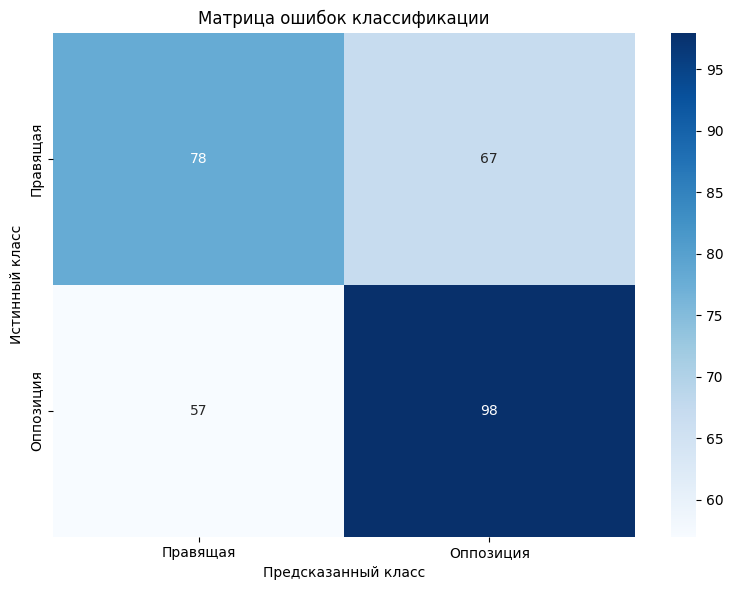

Значения матрицы ошибок:
True Negative (TN): 78 - правильно предсказаны случаи правящей партии
False Positive (FP): 67 - ошибка I рода (ложная оппозиция)
False Negative (FN): 57 - ошибка II рода (пропущенная оппозиция)
True Positive (TP): 98 - правильно предсказаны случаи оппозиции

3. ROC-КРИВЫЕ ДЛЯ КАЖДОГО КЛАССА:


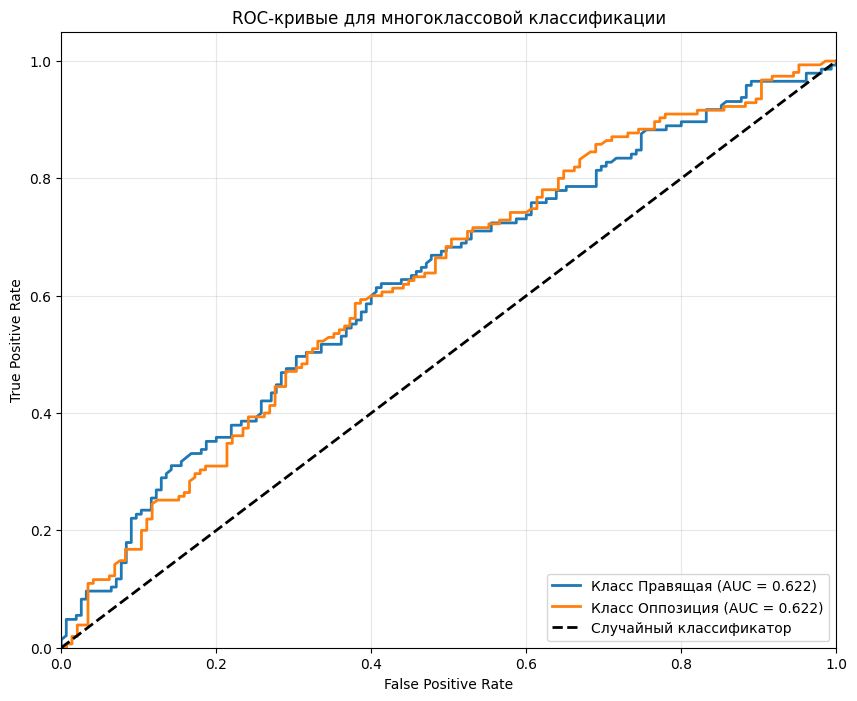

In [19]:
# 7: ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССИФИКАЦИИ
# 7.1. Отчет классификации
print("\n1. ОТЧЕТ КЛАССИФИКАЦИИ (classification_report):")
print(classification_report(y_true, y_pred, 
                          target_names=['Правящая партия', 'Оппозиция']))

# 7.2. Матрица ошибок
print("\n2. МАТРИЦА ОШИБОК (Confusion Matrix):")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Правящая', 'Оппозиция'],
            yticklabels=['Правящая', 'Оппозиция'])
plt.title('Матрица ошибок классификации')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

print(f"Значения матрицы ошибок:")
print(f"True Negative (TN): {cm[0,0]} - правильно предсказаны случаи правящей партии")
print(f"False Positive (FP): {cm[0,1]} - ошибка I рода (ложная оппозиция)")
print(f"False Negative (FN): {cm[1,0]} - ошибка II рода (пропущенная оппозиция)")
print(f"True Positive (TP): {cm[1,1]} - правильно предсказаны случаи оппозиции")

# 7.3. ROC-кривые
print("\n3. ROC-КРИВЫЕ ДЛЯ КАЖДОГО КЛАССА:")
plt.figure(figsize=(10, 8))

# Для каждого класса
for i in range(2):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, 
             label=f'Класс {["Правящая", "Оппозиция"][i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для многоклассовой классификации')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


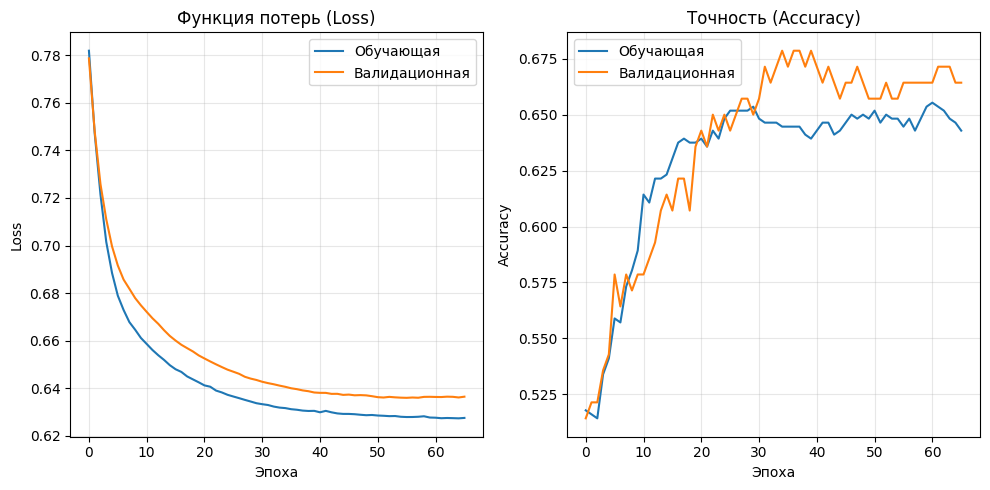

In [29]:
# 8: ВИЗУАЛИЗАЦИЯ ПРОЦЕССА ОБУЧЕНИЯ
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 1. Loss функция
axes[0].plot(history.history['loss'], label='Обучающая')
axes[0].plot(history.history['val_loss'], label='Валидационная')
axes[0].set_title('Функция потерь (Loss)')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Accuracy
axes[1].plot(history.history['accuracy'], label='Обучающая')
axes[1].plot(history.history['val_accuracy'], label='Валидационная')
axes[1].set_title('Точность (Accuracy)')
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
